In [18]:
%%HTML
<style>
	@import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

	body {
		font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
		line-height: 1.67;
	}
</style>

# Dynamic Periodic ETC for LPV Models under Saturation

_**[Event-based Control](https://github.com/andel-vitorio/event-based-control.git)**_

_by Andevaldo da Encarnação Vitório ([andevaldo.vitorio@icomp.ufam.edu.br](mailto:andevaldo.vitorio@icomp.ufam.edu.br)), last updated: April 20, 2025_

<!-- This notebook presents the implementation of the mathematical modeling and controller for a DC microgrid, represented by a buck converter with a CPL (Constant Power Load). The buck converter is a power conversion device that steps down a high DC voltage to a lower one. The CPL is a load that demands constant power regardless of variations in input voltage.

For the implementation, Python libraries such as Control, NumPy, and Matplotlib will be used. During implementation, the nonlinear system, shifted nonlinear system, and linearized system, all derived from the mathematical modeling, will be explored. -->

<!-- Detailed mathematical modeling can be found in the separate document titled ["Mathematical Modeling of a Microgrid"](../docs/Mathematical%20Modeling%20of%20a%20Microgrid.md), located in the `docs` directory.  -->

## 1. Importing Libraries

In [19]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from control.matlab import *  # type: ignore
import control.optimal as opt  # type: ignore
import control as ct  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import sys, os, json

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

utils_path = os.path.abspath(os.path.join("..", "Utils"))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Import utility functions from custom modules
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)

# Set the use of feedback standards for the control package
ct.use_fbs_defaults()

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


## 2. LPV Model

## Predefinição da Simulação

In [20]:
def get_A(params):
  # A11 = -5.
  # A12 = 8.
  # A21 = -9.
  # A22 = -5.

  OP = params['op']

  A11 = - (params['rL'] / params['L'])
  A12 = - (1. / params['L'])
  A21 = 1. / params['C']
  A22 = (1. / params['C']) * (OP['Pcpl'] /
                              (OP['vC'] ** 2) - 1. / params['rC'])

  return np.array([[A11, A12],
                   [A21, A22]])


def get_B(params, σ):
  B11 = params['Vin'] / params['L']
  B21 = 0.
  B = np.array([[B11],
                [B21]])
  return B @ nm.diag(σ)


def plant_update(time, states, inputs, params):
  σ = params['σ']

  A = get_A(params)
  B = get_B(params, σ)

  x = states.reshape(-1, 1)
  u = inputs[0:1].reshape(-1, 1)

  # Computing the time derivative of the states (x_dot)
  x_dot = A @ x + B @ u

  return x_dot


# Assuming control library's nlsys function is used here
plant = ct.nlsys(plant_update, None, name="plant",
                 inputs=('u1'), outputs=('x1', 'x2'),
                 states=('x1', 'x2'))

# Printing the plant system
print(plant)

<NonlinearIOSystem>: plant
Inputs (1): ['u1']
Outputs (2): ['x1', 'x2']
States (2): ['x1', 'x2']

Update: <function plant_update at 0x7787fcf90e00>
Output: None


In [21]:
# import numpy as np


# def piecewise_linear(timepts, points):
#   """
#   Generate a piecewise linear function defined by (time, value) pairs.

#   Parameters
#   ----------
#   timepts : array_like
#       Array of time points where the function should be evaluated.
#   points : list of tuple
#       List of (time, value) pairs defining the piecewise linear function.

#   Returns
#   -------
#   values : np.ndarray
#       Array of function values at the given timepts.
#   """
#   timepts = np.asarray(timepts)
#   points = sorted(points)  # Ensure the points are sorted by time

#   # Unzip times and values
#   times, values = zip(*points)

#   # Use numpy interpolation (linear by default)
#   return np.interp(timepts, times, values, left=0.0, right=0.0)

In [22]:
def create_params(V_IN, RL, RC, L, C, PCPL_OP, VC_OP):
  """
  Create a dictionary of parameters for the system model.

  Parameters:
                  V_IN (float): Input voltage.
                  RL (float): Resistance of the inductor.
                  RC (float): Resistance of the capacitor.
                  L (float): Inductance.
                  C (float): Capacitance.
                  PCPL_OP (float): Operating power of the CPL.
                  VC_OP (float): Operating voltage of the capacitor.

  Returns:
                  dict: Dictionary of system parameters.

  """
  # Calculate the operating point (OP) values for inductor current and duty cycle
  IL_OP = (VC_OP / RC) + PCPL_OP / VC_OP
  D_OP = (RL * IL_OP) / V_IN + VC_OP / V_IN

  # Create the dictionary of parameters
  params = {
      "Vin": V_IN,
      "rL": RL,
      "rC": RC,
      "L": L,
      "C": C,
      "op": {"Pcpl": PCPL_OP, "vC": VC_OP, "iL": IL_OP, "d": D_OP},
  }

  return params

In [23]:
simulation_step = 1e-6
simulation_time = .1
timepts = np.arange(0, simulation_time + simulation_step, simulation_step)

# # Input for open-loop simulation
u1 = np.zeros((1, len(timepts)))

params = create_params(
    V_IN=24, RL=0.01, RC=10, L=1e-3,
    C=2.2e-3, PCPL_OP=20, VC_OP=9
)

params['σ'] = [1.]
print(params)


X0 = [1e-2, 1e-2]

print(get_B(params, params['σ']))

{'Vin': 24, 'rL': 0.01, 'rC': 10, 'L': 0.001, 'C': 0.0022, 'op': {'Pcpl': 20, 'vC': 9, 'iL': 3.1222222222222222, 'd': 0.3763009259259259}, 'σ': [1.0]}
[[24000.]
 [    0.]]


## Simulação da Planta em Malha Aberta

In [24]:
t, y = ct.input_output_response(
    sys=plant, T=timepts,
    U=[u1],
    X0=X0, params=params
)

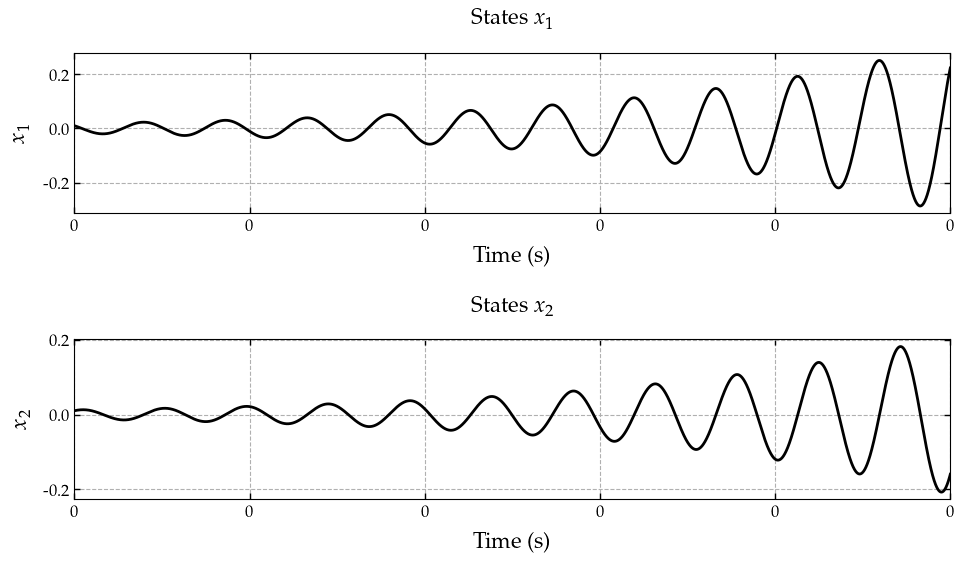

In [25]:
fig = plt.figure(figsize=(10, 6), layout='constrained')
axs = fig.subplot_mosaic([["x1"], ["x2"]])

plot_cfg = {
    'style': {
        'color': 'black'
    },
    'limits': {
        'x_min': t[0],
        'x_max': t[-1],
    },
    'axis': {
        'x_label_fontsize': 16,
        'y_label_fontsize': 16,
        'x_digits': 0,
        'y_digits': 1,
    }
}

for i in [0, 1]:
  gph.plot(axs[f'x{i+1}'], t, y[i],
           xlabel='Time (s)', ylabel=f'$x_{i+1}$',
           title=f'States $x_{i+1}$', plot_cfg=plot_cfg)
plt.tight_layout(pad=2.)

In [26]:
def He(M): return M + M.T


def get_parameter(params, h, υ, σ, ρ, K, eps=1e-6):

  n_u = 1
  n_x = 2

  Onx = np.zeros((n_x, n_x))
  O2nx = np.zeros((2 * n_x, 2 * n_x))

  A = get_A(params)
  Bf = get_B(params, σ)
  Cf = nm.diag(ρ)

  e = {}
  _es = np.eye(n_x)
  _ef = np.zeros((n_x, 6 * n_x))
  e[1] = np.block([[_es, _ef, np.zeros((n_x, 2 * n_u + n_x))]])
  e[7] = np.block([[_ef, _es, np.zeros((n_x, 2 * n_u + n_x))]])

  for i in range(2, 7):
    e[i] = np.block([[np.zeros((n_x, n_x * (i - 1))),
                      np.eye(n_x),
                      np.zeros((n_x, n_x * (7 - i))),
                      np.zeros((n_x, 2 * n_u + n_x))]])
  # e[8] = np.block([[np.zeros((n_r,  7 * n_x)),
  #                   np.eye(n_r), np.zeros((n_r, n_r + 2 * n_u + n_x))]])
  # e[9] = np.block([[np.zeros((n_r,  7 * n_x)),
  #                   np.zeros((n_r, n_r)), np.eye(n_r),
  #                   np.zeros((n_r, 2 * n_u + n_x))]])
  e[8] = np.block([[np.zeros((n_u,  7 * n_x)),
                    np.eye(n_u), np.zeros((n_u, n_u + n_x))]])
  e[9] = np.block([[np.zeros((n_u,  7 * n_x + n_u)),
                    np.eye(n_u), np.zeros((n_u, n_x))]])
  e[10] = np.block([[np.zeros((n_x,  7 * n_x + 2 * n_u)),
                     np.eye(n_x)]])

  for i in range(1, 11):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  # print(e[9].value)

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Stil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((n_x, n_x))

  Pcal = cp.bmat([[Ptil,   Mtil],
                  [Mtil.T, Stil]])

  constraints = []

  Rc1_til = cp.Variable((n_u, n_u), name='Rutil')
  Rc2_til = cp.Variable((n_u, n_x), name='Rc2_til')
  K_til = cp.Variable((n_u, n_x), name='Ktil')
  Ry_til = cp.Variable((n_x, n_x), name='Rytil')

  Util = cp.Variable((n_x, n_x), PSD=True)
  Vtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  Ψtil = cp.Variable((n_x, n_x), PSD=True)

  X1 = cp.Variable((n_x, n_x))
  X2 = cp.Variable((n_u, n_u))
  X3 = cp.Variable((n_u, n_x))
  X4 = cp.Variable((n_u, n_x))

  Y1til = cp.Variable((2 * n_x, 2 * n_x))
  Y2til = cp.Variable((2 * n_x, 2 * n_x))

  Rcal = cp.bmat([[Vtil,  Onx],
                  [Onx,   3. * Vtil]])

  # Fscr1 = e[1].T + υ[1] * e[2].T + υ[1] * \
  #     e[3].T + υ[1] * e[4].T + υ[1] * e[5].T + \
  #     υ[1] * e[6].T + υ[1] * e[7].T + υ[1] * e[10].T
  # Fscr2 = e[8].T + υ[2] * e[9].T
  # Fscr3 = e[8].T + υ[3] * e[9].T
  # Fscr4 = e[1].T + υ[4] * e[2].T + υ[4] * \
  #     e[3].T + υ[4] * e[4].T + υ[4] * e[5].T + \
  #     υ[4] * e[6].T + υ[4] * e[7].T + υ[4] * e[10].T

  Fscr1 = e[1].T + υ[1] * e[2].T + υ[1] * e[3].T
  Fscr2 = e[8].T + υ[2] * e[9].T
  Fscr3 = e[8].T + υ[3] * e[9].T
  Fscr4 = e[1].T + υ[4] * e[2].T + υ[4] * e[3].T

  Fscr = cp.bmat([[Fscr1, Fscr2, Fscr3, Fscr4]])

  Π = cp.bmat([[e[1] - e[3]],
              [e[1] + e[3] - 2 * e[5]],
              [e[3] - e[4]],
              [e[3] + e[4] - 2 * e[6]]])

  κ1 = {}
  κ1['0'] = cp.bmat([[e[1]], [h * e[6]]])
  κ1['h'] = cp.bmat([[e[1]], [h * e[5]]])

  κ2 = cp.bmat([[e[2]], [e[1] - e[4]]])

  def get_Λ():
    Bscr_til1 = A @ X1 @ e[1] - X1 @ e[2] + Bf @ X2 @ e[8]
    Bscr_til2 = Rc2_til @ e[3] - Rc2_til @ e[7] - X2 @ e[8] + Rc1_til @ e[9]
    Bscr_til3 = - X2 @ e[9] + K_til @ e[10]
    Bscr_til4 = Ry_til @ e[3] - Ry_til @ e[7] - X1 @ e[10]

    Bscr_til = cp.bmat([[Bscr_til1], [Bscr_til2],
                        [Bscr_til3], [Bscr_til4]])

    Φtil = {}

    Φtil1 = cp.bmat([[Rcal, O2nx],
                    [O2nx, Rcal]])
    Φtil2 = cp.bmat([[Rcal, Y2til], [Y2til.T, O2nx]])
    Φtil3 = cp.bmat([[O2nx, Y1til], [Y1til.T, Rcal]])

    Φtil['0'] = Φtil1 + Φtil2
    Φtil['h'] = Φtil1 + Φtil3

    Θtil = {}
    Θtil['0'] = 2 * κ1['0'].T @ Pcal @ κ2 + e[1].T @ Util @ e[1] - e[4].T @ Util @ e[4] + \
        (h ** 2) * e[2].T @ Vtil @ e[2] - e[7].T @ Cf.T @ Ξtil @ Cf @ e[7] + \
        He(Fscr @ Bscr_til) - Π.T @ Φtil['0'] @ Π

    Θtil['h'] = 2 * κ1['h'].T @ Pcal @ κ2 + e[1].T @ Util @ e[1] - e[4].T @ Util @ e[4] + \
        (h ** 2) * e[2].T @ Vtil @ e[2] - e[7].T @ Cf.T @ Ξtil @ Cf @ e[7] + \
        He(Fscr @ Bscr_til) - Π.T @ Φtil['h'] @ Π

    Γ1_11 = Θtil['0']
    Γ1_12 = Π.T @ cp.bmat([[Y1til], [O2nx]])
    Γ1_13 = e[3].T @ X1.T @ Cf.T

    Γ1_21 = Γ1_12.T
    Γ1_22 = - Rcal
    Γ1_23 = np.zeros((2 * n_x, n_x))

    Γ1_31 = Γ1_13.T
    Γ1_32 = Γ1_23.T
    Γ1_33 = - Ψtil

    Γ1 = cp.bmat([[Γ1_11, Γ1_12, Γ1_13],
                  [Γ1_21, Γ1_22, Γ1_23],
                  [Γ1_31, Γ1_32, Γ1_33]])

    Γ2_11 = Θtil['h']
    Γ2_12 = Π.T @ cp.bmat([[O2nx], [Y2til.T]])
    Γ2_13 = e[3].T @ X1.T @ Cf.T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - Rcal
    Γ2_23 = np.zeros((2 * n_x, n_x))

    Γ2_31 = Γ2_13.T
    Γ2_32 = Γ2_23.T
    Γ2_33 = - Ψtil

    Γ2 = cp.bmat([[Γ2_11, Γ2_12, Γ2_13],
                  [Γ2_21, Γ2_22, Γ2_23],
                  [Γ2_31, Γ2_32, Γ2_33]])

    return Γ1, Γ2

  Λ = {}
  Λ['0'], Λ['h'] = get_Λ()
  constraints += [Λ['0'] << -eps * np.eye(Λ['0'].shape[0])]
  constraints += [Λ['h'] << -eps * np.eye(Λ['h'].shape[0])]

  constraints += [Pcal >> eps * np.eye(Pcal.shape[0])]

  obj = cp.Minimize(cp.trace(Ξtil + Ψtil))
  # obj = cp.Minimize(0.)
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    # print("Optimal value: %s\n" % prob.value)

    # matrix_utils.show_matrix(Ξtil.value, 'Ξtil')

    X1_inv = np.linalg.inv(X1.value)
    X2_inv = np.linalg.inv(X2.value)
    Ξ = X1_inv.T @ Ξtil.value @ X1_inv
    Ψ = np.linalg.inv(Ψtil.value)

    P = X1_inv.T @ Ptil.value @ X1_inv
    M = X1_inv.T @ Mtil.value @ X1_inv
    S = X1_inv.T @ Stil.value @ X1_inv
    U = X1_inv.T @ Util.value @ X1_inv
    V = X1_inv.T @ Vtil.value @ X1_inv

    Rc1 = Rc1_til.value @ X2_inv
    Rc2 = Rc2_til.value @ X1_inv
    K = K_til.value @ X1_inv
    Ry = Ry_til.value @ X1_inv

    Pcal_ = np.block([[P, M], [M.T, S]])

    # matrix_utils.show_matrix(Ptil.value, 'Ptil')

    P_eig = np.linalg.eig(P)[0]
    S_eig = np.linalg.eig(S)[0]
    Pcal_eig = np.linalg.eig(Pcal_)[0]

    error = False

    # for i in range(n_x):
    #   if P_eig[i] <= 0:
    #     print("P não é definida positiva!")
    #     error = True
    #   if S_eig[i] <= 0:
    #     print("S não é definida positiva!")
    #     error = True

    # print('Autovalores de Pcal: ', Pcal_eig)
    for eig in Pcal_eig:
      if eig <= 0:
        print("Pcal não é definida positiva!")
        error = True

    if error == False:
      # K = Ktil.value @ Xxinv
      # matrix_utils.show_matrix(K, f'K{i}')

      # matrix_utils.show_matrix(Ξ, 'Ξ')
      # matrix_utils.show_matrix(Ψ, 'Ψ')

      design_results = {
          'optimal_value': prob.value,
          'etm': {'Ξ': Ξ, 'Ψ': Ψ},
          'rb': {'Rc1': Rc1, 'Rc2': Rc2, 'Ry': Ry, 'K': K},
          'lyapunov': {'P': P, 'M': M, 'S': S, 'U': U, 'V': V},
          # 'bounds': {'β': β.value, 'ρ': ρ.value, 'γ': γ.value}
      }
  else:
    # print('The problem is not feasible')
    design_results = None

  return design_results

In [27]:
σ = params['σ']
ρ = [1., 1.]
h = 10e-4
υ = {1: 1e-2,
     2: 1e-2,
     3: 1e-2,
     4: 1e-2}

K = np.array([[-1.61e-1, 9.55e-2]])

design_results = get_parameter(params, h, υ, σ, ρ, K, eps=1e-10)

Rc1 = None
Rc2 = None
Ry = None

if design_results is not None:
  Ξ = design_results['etm']['Ξ']
  Ψ = design_results['etm']['Ψ']
  P = design_results['lyapunov']['P']
  M = design_results['lyapunov']['M']
  S = design_results['lyapunov']['S']
  Q = design_results['lyapunov']['U']
  R = design_results['lyapunov']['V']
  Rc1 = design_results['rb']['Rc1']
  Rc2 = design_results['rb']['Rc2']
  Ry = design_results['rb']['Ry']
  K = design_results['rb']['K']

  print('Resultados:')
  display(Math(rf'f^\star =' + tex.dec2tex(design_results['optimal_value'])))

  print('Matrizes de Acionamento:')
  display(Math(rf'\Xi = ' + tex.mat2tex(Ξ)))
  display(Math(rf'\Psi = ' + tex.mat2tex(Ψ)))

  print('Matrizes do RB:')
  display(Math(rf'R_{{c,1}} = ' + tex.mat2tex(Rc1)))
  display(Math(rf'R_{{c,2}} = ' + tex.mat2tex(Rc2)))
  display(Math(rf'R_y = ' + tex.mat2tex(Ry)))
  display(Math(rf'K = ' + tex.mat2tex(K)))

else:
  print('Problema não é factível!')

Resultados:


<IPython.core.display.Math object>

Matrizes de Acionamento:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Matrizes do RB:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [28]:
class DynamicETM:
  def __init__(self, name, Ψ, Ξ, θ, λ, T):
    self.name = name
    self.previous_time = 0
    self.first_simulation = True
    self.event_times = [0.]
    self.next_sampling_time = 0.
    self.last_time = 0.
    self.last_sampled_states = []
    self.last_printed_sampling_time = -1.

    # Matrizes de Acionamento
    self.Ξ = Ξ
    self.Ψ = Ψ
    self.T = T

    self.θ = θ
    self.λ = λ
    self.system = ct.NonlinearIOSystem(
        self.etm_update, self.etm_output,
        name=self.name, states=['n'],
        inputs=['x1_hat', 'x2_hat', 'x1', 'x2'],
        outputs=['n', 'x1', 'x2']
    )

  def etm_update(self, t, n, u, params):
    # Obtenção do último estado transmitido e o estado atual
    x_hat = np.array(u[0:2]).reshape(-1, 1)
    x = np.array(u[2:4]).reshape(-1, 1)

    # Verifica se ocorrerá um novo evento de transmissão
    new_event = False
    is_sampling_instant = False
    if t >= self.next_sampling_time:
      ε = x_hat - x
      Tcal = x.T @ self.Ψ @ x - ε.T @ self.Ξ @ ε
      new_event = n[0] + self.θ * Tcal < 0
      is_sampling_instant = True

    # Obtenção do x(t - τ)
    xτ = self.last_sampled_states  # Para t != nh
    if is_sampling_instant:
      xτ = x.copy()                # Para t == nh

    # Verifica a atualização de x_hat e ε
    ε = x_hat - xτ
    if new_event == True or t == 0.:
      x_hat = x.copy()
      ε = np.zeros((2, 1))

    # Atualiza a variável dinâmica
    Tcal = xτ.T @ self.Ψ @ xτ - ε.T @ self.Ξ @ ε
    n_dot = - self.λ * n + Tcal

    return n_dot

  def etm_output(self, t, n, u, params):
    if t != self.previous_time:
      if self.previous_time >= self.next_sampling_time:
        self.next_sampling_time += self.T

      if self.first_simulation and t == 0.:
        self.first_simulation = False
        self.previous_time = 0
        self.last_printed_sampling_time = -1.

      if t == 0.:
        self.last_time = 0.
        self.next_sampling_time = 0.
      elif t < self.previous_time:
        assert 'Integração Retrógrada'

      self.previous_time = t

    x_hat = np.array(u[0:2]).reshape(-1, 1)
    x = np.array(u[2:4]).reshape(-1, 1)
    new_event = False

    if (t >= self.next_sampling_time):
      if (t != self.last_printed_sampling_time):
        print(f'Sampling Time: {t:.3f}')
        self.last_printed_sampling_time = t

      ε = x_hat - x
      Tcal = x.T @ self.Ψ @ x - ε.T @ self.Ξ @ ε
      new_event = (n[0] + self.θ * Tcal < 0.) or (t == 0.)
      self.last_sampled_states = x

    if self.first_simulation and new_event and self.event_times[-1] != t:
      print('Event Time: ', t)
      self.event_times.append(t)

    x_to_send = x if new_event else x_hat

    return np.concatenate((n, x_to_send.reshape(-1)))

In [29]:
class ZeroOrderHold:
  def __init__(self):
    self.previous_time = 0
    self.previous = []
    self.last_samples_sent = [0., 0.]
    self.system = ct.nlsys(
        None, self.zoh_output,
        name='zoh',
        inputs=['x1', 'x2'],
        outputs=['x1_hat', 'x2_hat'],
    )

  def zoh_output(self, t, x, u, params):
    if t != self.previous_time:
      self.last_samples_sent = self.previous
      self.previous_time = t
    self.previous = u
    return self.last_samples_sent


class Controller:
  def __init__(self, K):
    self.K = K
    self.system = ct.nlsys(
        None, self.control_output,
        name='controller',
        inputs=['x1_hat', 'x2_hat',],
        outputs=['u1'],
    )

  def control_output(self, t, x, u, params):
    x_hat = u.reshape(-1, 1)
    yr = Ry @ x_hat
    uc = K @ yr
    ur = Rc1 @ uc + Rc2 @ x_hat
    return ur

In [30]:
# Nome do arquivo de experimento
experiment_name = "Results/1/Trajectories-N1.json"
λ = 1e-5
# Define se as simulações devem ser forçadas mesmo se o arquivo já existir
force_simulation = True
simulations_amount = 1

# Estrutura para armazenar os resultados
results_clsim = {
    'trajectories': [],
    'inter-event-times': []
}

# Verificar se o arquivo já existe
if os.path.exists(experiment_name) and not force_simulation:
  print(f"O arquivo {experiment_name} já existe. Carregando dados salvos.")
  with open(experiment_name, "r") as f:
    results_clsim = json.load(f)
else:
  def get_trajectories(i):
    θ = (1. / λ) * (np.exp(λ * h) - 1.)

    etm = DynamicETM('etm', Ψ, Ξ, θ, λ, h)
    zoh = ZeroOrderHold()
    controller = Controller(K)

    closed_loop = ct.interconnect(
        (plant, etm.system, zoh.system, controller.system),
        connections=[
            ['plant.u1', 'controller.u1'],

            ['etm.x1_hat', 'zoh.x1_hat'],
            ['etm.x2_hat', 'zoh.x2_hat'],

            ['etm.x1', 'plant.x1'],
            ['etm.x2', 'plant.x2'],

            ['zoh.x1', 'etm.x1'],
            ['zoh.x2', 'etm.x2'],

            ['controller.x1_hat', 'zoh.x1_hat'],
            ['controller.x2_hat', 'zoh.x2_hat'],
        ],
        name='closed-loop system',
        outlist=['etm.n', 'plant.x1', 'plant.x2', 'controller.u1'],
    )

    etm.event_times = [0.]

    _, trajectories = ct.input_output_response(
        sys=closed_loop, T=timepts,
        # X0=[initial_states_list[0][i], initial_states_list[1][i], 0.],
        X0=[X0[0], X0[1], 0.],
        params=params,
        solve_ivp_method='RK45',
        solve_ivp_kwargs={'max_step': simulation_step,
                          'first_step': simulation_step,
                          'atol': 1e-2, 'rtol': 1e-2},
    )

    inter_event_times = np.diff(etm.event_times).tolist()

    return {'trajectories': trajectories.tolist(), 'inter-event-times': inter_event_times}

  # Paralelismo com ProcessPoolExecutor
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories,
                                range(simulations_amount)))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim['trajectories'].append(res['trajectories'])
    results_clsim['inter-event-times'].append(res['inter-event-times'])

  # Salvar resultados em um arquivo JSON
  with open(experiment_name, "w") as f:
    json.dump(results_clsim, f, indent=4)

  print(f"Simulações concluídas. Resultados salvos em {experiment_name}.")

Sampling Time: 0.000
Sampling Time: 0.001
Sampling Time: 0.002
Sampling Time: 0.003
Sampling Time: 0.004
Sampling Time: 0.005
Sampling Time: 0.006
Sampling Time: 0.007
Sampling Time: 0.008
Sampling Time: 0.009
Sampling Time: 0.010
Sampling Time: 0.011
Sampling Time: 0.012
Sampling Time: 0.013
Sampling Time: 0.014
Sampling Time: 0.015
Sampling Time: 0.016
Sampling Time: 0.017
Sampling Time: 0.018
Sampling Time: 0.019
Sampling Time: 0.020
Sampling Time: 0.021
Sampling Time: 0.022
Sampling Time: 0.023
Sampling Time: 0.024
Sampling Time: 0.025
Sampling Time: 0.026
Sampling Time: 0.027
Sampling Time: 0.028
Sampling Time: 0.029
Sampling Time: 0.030
Sampling Time: 0.031
Sampling Time: 0.032
Sampling Time: 0.033
Sampling Time: 0.034
Sampling Time: 0.035
Sampling Time: 0.036
Sampling Time: 0.037
Sampling Time: 0.038
Sampling Time: 0.039
Sampling Time: 0.040
Sampling Time: 0.041
Sampling Time: 0.042
Sampling Time: 0.043
Sampling Time: 0.044
Sampling Time: 0.045
Sampling Time: 0.046
Sampling Time

In [31]:
# B1 = nm.binary_set(1)
# u_max = u_bar[0]

# x_vals = np.linspace(-.5, .5, 200)
# y_vals = np.linspace(-1, 1, 200)

# X, Y = np.meshgrid(x_vals, y_vals)
# points = np.vstack([X.ravel(), Y.ravel()]).T

# valid_points = np.ones(X.shape, dtype=bool)

# for b in B1:
#   K_b = K[b]
#   G_b = G[b]
#   K_minus_G = K_b - G_b
#   result = np.abs(np.dot(points, K_minus_G.T))
#   valid_points &= (result.reshape(X.shape) <= u_max)

In [32]:
# %matplotlib inline

# x1_range = (-.5, .5)
# x2_range = (-.5, .5)

# trajectories = results_clsim['trajectories']

# fig, ax = plt.subplots(1, 1, figsize=(6., 6.))
# fig.canvas.manager.set_window_title(
#     "Região de Estabilidade Externa/Estados Iniciais Admissíveis")

# ax.contour(X1, X2, V_values, levels=[1. / β],
#             colors='black', linestyles='--')


# for trajectory in trajectories:
#   ax.plot(trajectory[1], trajectory[2], color='black', linestyle=':')

# # contour = ax.contour(X, Y, valid_points,
# #                      colors='#363636', linewidths=1.)

# # ax.plot(initial_states_list[0], initial_states_list[1], '*',
# #          linestyle='None', c='black', markersize=10)

# # ax.set_xlabel("$x_1$", fontsize=14)
# # ax.set_ylabel("$x_2$", fontsize=14, labelpad=0.)
# # ax.tick_params(axis='both', direction='in', length=4, width=1,
# #                colors='black', top=True, right=True, labelsize=14)
# # ax.grid(True, linestyle='--', alpha=0.6)


# # elements = [
# #     ('line', {'color': '#363636', 'linestyle': '-', 'linewidth': 1.}),
# #     ('line', {'color': 'black', 'linestyle': '-', 'linewidth': 2.}),
# #     ('line', {'color': 'black', 'linestyle': ':', 'linewidth': 2.}),
# #     ('marker', {'marker': '*', 'color': 'red', 'markersize': 10})
# # ]

# # labels = ['${\\cal D}_u$', '${\\cal D}_x$',
# #           'Trajetórias', 'Pontos Iniciais']

# # gph.create_custom_legend(ax, elements, labels)

# plt.tight_layout()

In [33]:
%matplotlib qt

fig, axs = plt.subplot_mosaic([['η'], ['sat'], ['x'], ['iet']], 
                              figsize=(6, 14))

trajectories = results_clsim['trajectories']
trajectories_index = 0

inter_event_times = results_clsim['inter-event-times'][trajectories_index]
event_times = np.cumsum(inter_event_times)

# print("Initial States: ", trajectories[trajectories_index][2][0])
# print("Number of Triggered Events: ", len(inter_event_times))
# print("Minimum IET Obtained: ", min(inter_event_times))
# print("Maximum IET Obtained: ", max(inter_event_times))
# print("Average Time Between Events: ", np.mean(inter_event_times))

plot_cfg = {
  'style': { 'color': 'black', },
  'axis': { 'title_pad': 8, 'y_digits': 0, 'x_digits': 0,
            'x_label_fontsize': 12,
            'y_label_fontsize': 12,
            'tick_fontsize': 12,},
  'limits': { 'x_min': 0.0, 'x_max': simulation_time }
}

gph.plot(
    axs['η'], t, trajectories[trajectories_index][0],
    xlabel='Time [s]', ylabel='$\\eta(t)$',
    title='ETM Dynamic Variable',
    plot_cfg=plot_cfg)

# axs['sat'].hlines([1., -1], 0, 5, colors='black', linestyles='--', label='$|\\bar u(t)|$')
# axs['sat'].legend(prop={'size': 16})

gph.plot(
    axs['sat'], t, 
    [v * 1e-4 for v in trajectories[trajectories_index][3]],
    xlabel='Time [s]', ylabel='$Q_g$ [kW]',
    title='Control Signal - Heat Flow', plot_cfg=plot_cfg)

gph.plot(
    axs['x'],
    t, trajectories[trajectories_index][2],
    xlabel='Time [s]', ylabel=r'$\theta_z$ [ºC]',
    title='Output - Internal Air Temperature',
    plot_cfg=plot_cfg)

gph.stem(
     axs['iet'], [et for et in event_times],
    [et for et in inter_event_times],
    stem_cfg=plot_cfg,
    xlabel='Time [s]', ylabel='$t_{k+1} - t_k$ ($s$)',
    title='Inter-event Times')

plt.tight_layout(pad=3.)

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
%%skip

import concurrent.futures
import numpy as np
import control as ct
import os
import json
import itertools
import pandas as pd

# Nome do arquivo de experimento

experiment_name = "Results/DPETC for Linear System under Disturbance/ETMParameters-N2.json"

# Definição dos parâmetros
upsilon_values = [1e-2, 1e0, 1e2]
theta_values = [1e-2, 1e-1, 1e0, 1e1, 1e2]

# Gerar combinações de upsilon e theta
upsilon_theta_pairs = list(itertools.product(upsilon_values, theta_values))

# Estrutura para armazenar os resultados
results_clsim_etm = {
    'upsilon_theta': [],
    'inter-event-times': [],
    'experiment_parameters': {
        'upsilon_values': upsilon_values,
        'theta_values': theta_values,
        'upsilon_theta_pairs': upsilon_theta_pairs,
    }
}

# Função para obter trajetórias


def get_trajectories(args):
  upsilon, theta = args
  etm = DynamicETM('etm', Ψ, Ξ, theta, upsilon, h)
  zoh = ZeroOrderHold()
  controller = Controller(K)

  closed_loop = ct.interconnect(
      (plant, etm.system, zoh.system, controller.system),
      connections=[
          ['plant.Qg', 'controller.u1'],

          ['etm.x1_hat', 'zoh.x1_hat'],
          ['etm.x2_hat', 'zoh.x2_hat'],

          ['etm.x1', 'plant.Θw'],
          ['etm.x2', 'plant.Θz'],

          ['zoh.x1', 'etm.x1'],
          ['zoh.x2', 'etm.x2'],

          ['controller.x1_hat', 'zoh.x1_hat'],
          ['controller.x2_hat', 'zoh.x2_hat'],
      ],
      name='closed-loop system',
      inplist=['plant.θ0', 'plant.Qs'],
      outlist=['etm.n', 'plant.Θz', 'controller.u1'],
  )

  etm.event_times = [0.]

  _, trajectories = ct.input_output_response(
      sys=closed_loop, T=timepts,
      U=[θ0, Qs],
      # X0=[initial_states_list[0][i], initial_states_list[1][i], 0.],
      X0=[0., 0., 0.],
      params=params,
      solve_ivp_method='RK45',
      solve_ivp_kwargs={'max_step': simulation_step,
                        'first_step': simulation_step,
                        'atol': 1e-2, 'rtol': 1e-2},
  )

  inter_event_times = np.diff(etm.event_times).tolist()
  avg_inter_event_time = np.mean(
      inter_event_times) if inter_event_times else 0

  return {'upsilon': upsilon, 'theta': theta, 'avg_inter_event_time': avg_inter_event_time}


# Verificar se o arquivo já existe
if os.path.exists(experiment_name):
  with open(experiment_name, "r") as f:
    results_clsim_etm = json.load(f)
else:
  # Executar experimentos se o arquivo não existir
  with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(get_trajectories, upsilon_theta_pairs))

  # Atualizar estrutura de resultados
  for res in results:
    results_clsim_etm['upsilon_theta'].append(
        (res['upsilon'], res['theta']))
    results_clsim_etm['inter-event-times'].append(
        res['avg_inter_event_time'])

  # Salvar resultados em um arquivo JSON
  with open(experiment_name, "w") as f:
    json.dump(results_clsim_etm, f, indent=4)

# print(results_clsim_etm)

# Criar DataFrame com colunas separadas para upsilon e theta
df = pd.DataFrame({
    'upsilon_theta': results_clsim_etm['upsilon_theta'],
    'inter-event-times': results_clsim_etm['inter-event-times']
})

# Separar as colunas de upsilon e theta
df[['upsilon', 'theta']] = pd.DataFrame(
    df['upsilon_theta'].tolist(), index=df.index)

# Criar tabela pivotada com upsilon nas colunas e theta nas linhas
pivot_df = df.pivot(index='theta', columns='upsilon',
                    values='inter-event-times')

# Exibir a tabela
print(pivot_df)

upsilon    0.01      1.00      100.00
theta                                
0.01     0.473992  0.470433  0.561629
0.10     0.585915  0.556437  0.530472
1.00     0.561528  0.547046  0.530701
10.00    0.492150  0.544488  0.521837
100.00   0.489666  0.532623  0.521837